## Task 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Считаем и отобразим данные

In [3]:
with np.load('data.npz') as data:
    A, C = data['A'], data["C"]

((25, 60), (1500, 816))

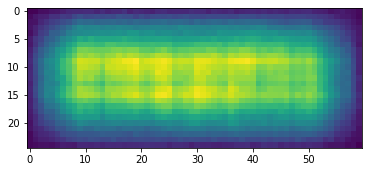

In [4]:
plt.imshow(A)
A.shape, C.shape

In [5]:
def mat2vec(A):
    h, w = A.shape
    a = np.zeros(h*w, dtype=A.dtype)
    A = np.flipud(A) 
    for i, row in enumerate(A):
        a[i*w:i*w+w] = row
    return a

In [6]:
def vec2mat(a, shape):
    h, w = shape
    A = np.zeros(shape, dtype=a.dtype)
    for i in range(h):
        A[i, :] = a[i*w:i*w+w]
    return np.flipud(A)

Посмотрим, как наш фильтр действует на картину

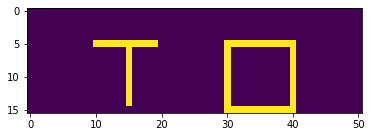

In [7]:
X = np.zeros((16,51))
X[5:15,15] = 1
X[5:15,30] = 1
X[5:15,40] = 1
X[5,10:20] = 1
X[5,30:41] = 1
X[15,30:41] = 1
plt.imshow(X)
plt.show()

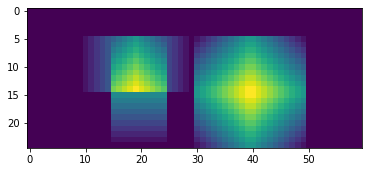

In [8]:
x = mat2vec(X)
plt.imshow(vec2mat(C @ x, (25, 60)))
plt.show()

Теперь найдем SVD разложение нашей матрицы C

In [10]:
u, s, vh = np.linalg.svd(C, full_matrices=False)
C.shape, s.shape

((1500, 816), (816,))

По размеру C видно, что система уравнений $a = Ca_0$ переопределена.

Будем решать ее методом наименьших квалратов, так как наша ошибка распределена норамльно. Для начала найдем решение "влом", с помощью псевдообратной матрицы С.

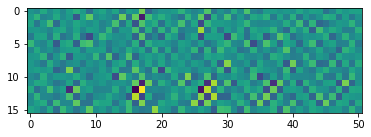

In [12]:
a = mat2vec(A)
a0 = np.linalg.pinv(C) @ a
A0 = vec2mat(a0, (16, 51))
plt.imshow(A0)
plt.show()

Ничего не видно и не понятно. Попробуем оставить в разложении матрицы С только первые n сингулярных значений.

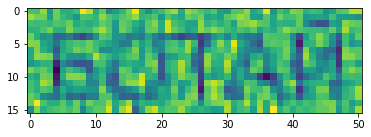

In [13]:
n = 370
s0 = np.zeros(816)
s0[:n] = s[:n]
C0 = np.dot(u, np.dot(np.diag(s0), vh))

A0_guess = vec2mat(np.linalg.pinv(C0) @ a, (16, 51))
plt.imshow(A0_guess)
plt.show()

Уже так можно прочитать, что написанно. Можно попробовать увеличить контрастность.

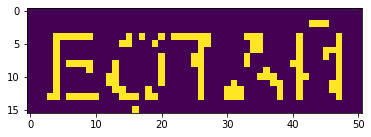

In [14]:
A1 = np.zeros((16, 51))
for i in range(A0_guess.shape[0]):
    for c in range(A0_guess.shape[1]):
        if A0_guess[i][c] < 110:
            A1[i][c] = 1
plt.imshow(A1)

Надпись предельно ясна, идем ботать

## Task 3

Запишем уравнения ньютона для k-го атома.

Пусть на нечетных позициях атомы массы М, а на четных м. Тогда запищем уравнения Ньютона для них:

$$M x_{k+1}'' = k(x_k - 2 x_{k+1}+ x_{k+2})$$
$$m x_k'' = k(x_{k-1} -2 x_k + x_{k+1})$$

Тогда в матричной форме можем записать:

$$\frac{d^2\vec{x}}{dt^2} + k A\vec{x} = 0$$
Запищем как выглядит матрица А:

\begin{equation*}
A = \left(
\begin{array}{cccc}
2 & -1 & 0 & \ldots & -1\\
-1/2 & 1 & -1/2 & \ldots & 0\\
0 & -1 & 2 &\ldots & 0\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \ldots & 2 & -1\\
-1/2 & 0 & \ldots & -1/2 & 1
\end{array}
\right)
\end{equation*}

В левом нижнем и правом верхнем углу не нули, так как цепочка замкнута.

In [15]:
def made_matrix_A (N):
    A = np.diag([2,1] * 2 * N) + np.diag(([-0.5, -1]* 2 * N)[:-1], -1) + np.diag(([-1, -0.5]* 2 * N)[:-1], 1)
    A[0, 4*N-1] = -1
    A[4*N-1, 0] = -0.5
    return A
made_matrix_A(2)

array([[ 2. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ],
       [-0.5,  1. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -1. ,  2. , -1. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -0.5,  1. , -0.5,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , -1. ,  2. , -1. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -0.5,  1. , -0.5,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. , -1. ,  2. , -1. ],
       [-0.5,  0. ,  0. ,  0. ,  0. ,  0. , -0.5,  1. ]])

In [63]:
eigenvals = np.linalg.eigvals(made_matrix_A(1000))

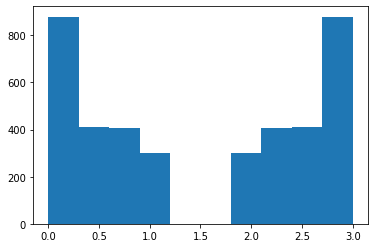

In [64]:
plt.hist(eigenvals)
plt.show()

In [23]:
eigen = np.linalg.eig(made_matrix_A(1000))

In [31]:
eimax = eigen[1][:,np.argmax(eigenvals)]
eimin = eigen[1][:,np.argmin(eigenvals)]

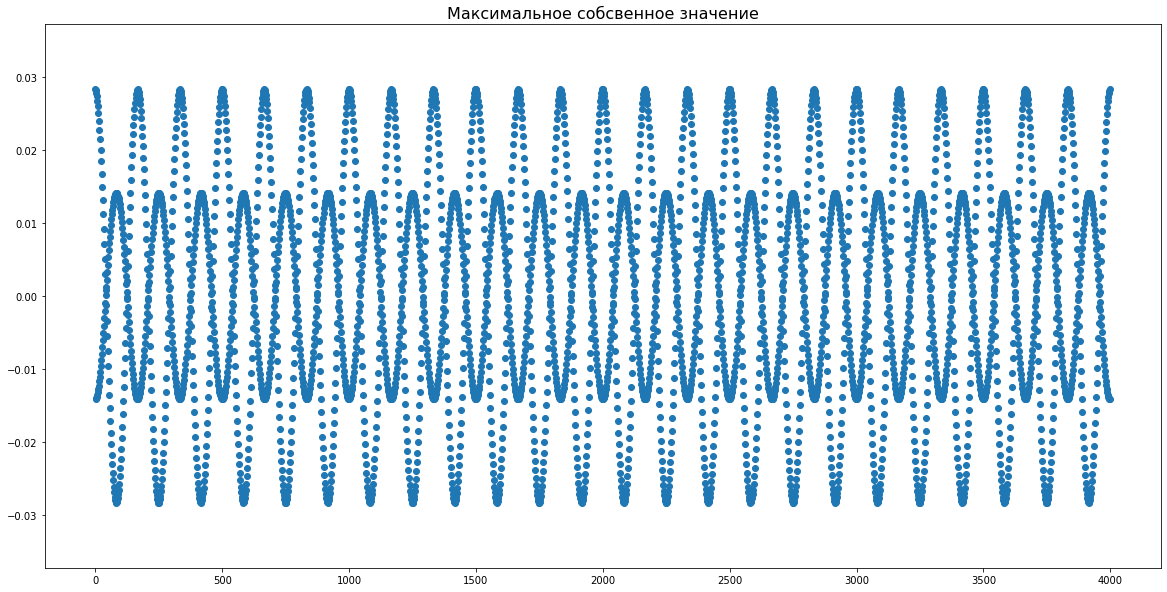

In [42]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(eimax)), eimax)
plt.title('Максимальное собсвенное значение', fontsize=16)
plt.show()

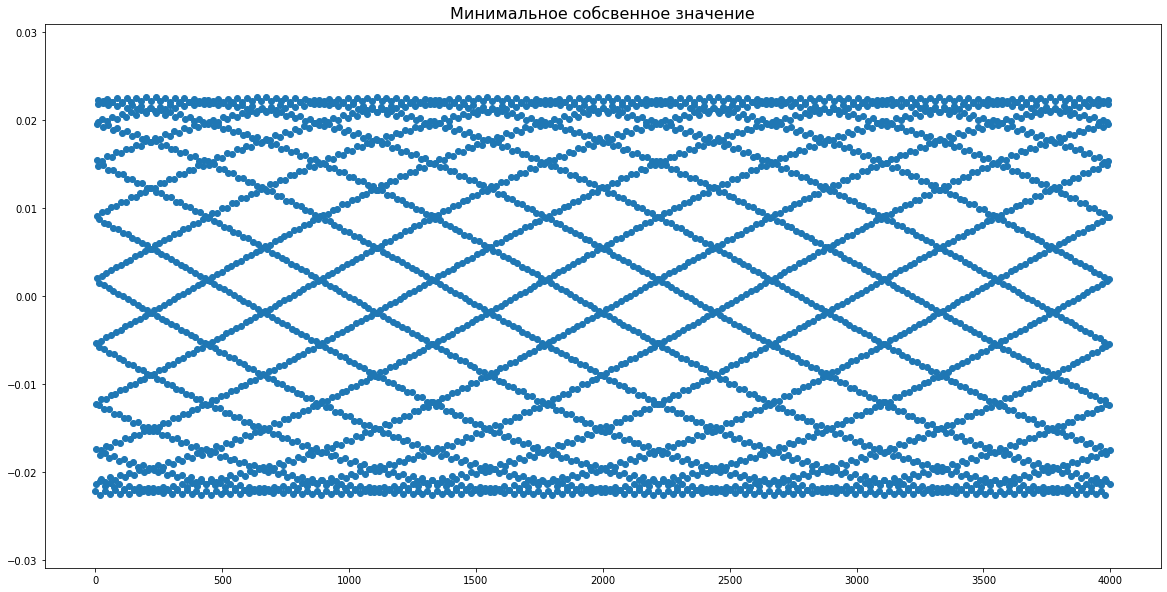

In [43]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(eimin)), eimin)
plt.title('Минимальное собсвенное значение', fontsize=16)
plt.show()

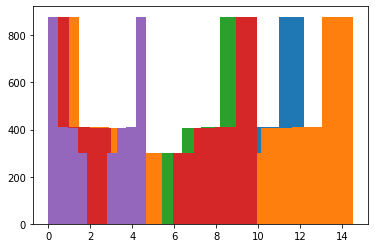

In [66]:
A = made_matrix_A(1000)
for i in range(5):
    k = np.random.random()*9 + 1
    A_k = k*A
    eigenvals_k = np.linalg.eigvals(A_k)
    eigen = np.linalg.eig(A_k)
    plt.hist(eigenvals_k)
plt.show()

Видно, что коэффициент просто увеличивает масштабы, не меняя картины в целом.

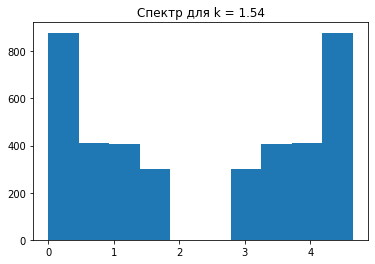

In [84]:
plt.title("Спектр для k = " + str(k)[:4])
plt.hist(eigenvals_k)
plt.show()

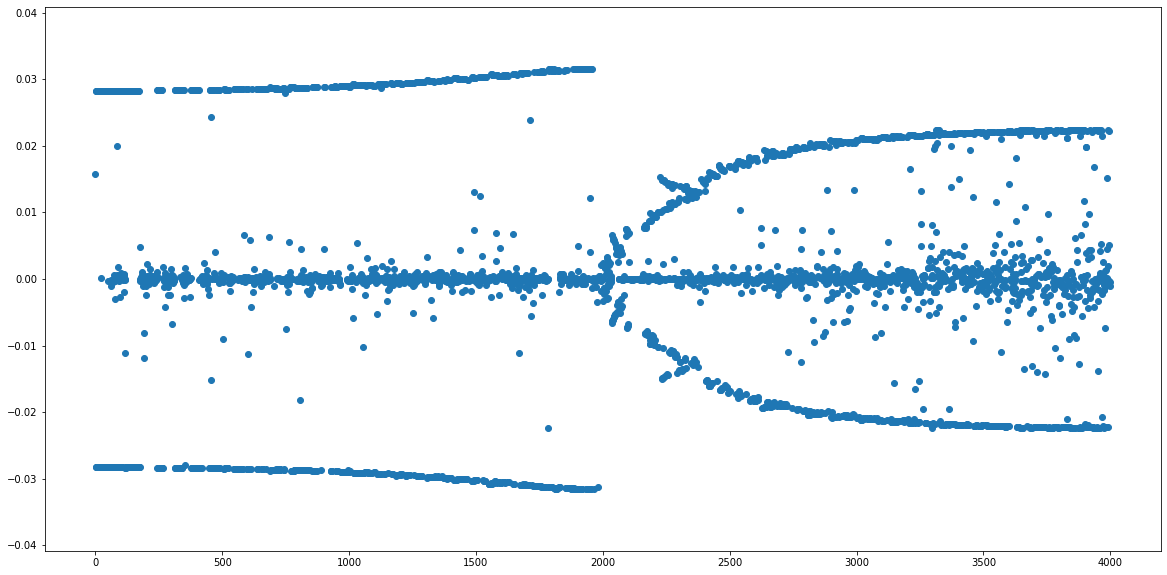

In [82]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(eigen[1][2000])), eigen[1][2000])
plt.show()